In [1]:
!pip install torch==1.2.0 torchvision==0.4.0

     |████████████████████████████████| 748.9MB 20kB/s 
     |████████████████████████████████| 8.8MB 20.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [37]:
import torch
torch.__version__

'1.2.0'

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
!cp -R /content/drive/MyDrive/11685deeplearning/hw4p1/handout /content

In [13]:
%cd /content/handout/hw4
!git clone https://github.com/salesforce/awd-lstm-lm.git

/content/handout/hw4
Cloning into 'awd-lstm-lm'...
remote: Enumerating objects: 137, done.
remote: Total 137 (delta 0), reused 0 (delta 0), pack-reused 137
Receiving objects: 100% (137/137), 57.62 KiB | 457.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [4]:
%cd /content/handout/hw4/awd-lstm-lm

/content/handout/hw4/awd-lstm-lm


In [5]:
# cp embed_regularize.py locked_dropout.py weight_drop.py /content/handout/hw4

In [6]:
from embed_regularize import embedded_dropout
from locked_dropout import LockedDropout
from weight_drop import WeightDrop

In [2]:
import numpy as np

def log_softmax(x, axis):
    ret = x - np.max(x, axis=axis, keepdims=True)
    lsm = np.log(np.sum(np.exp(ret), axis=axis, keepdims=True))
    return ret - lsm


def array_to_str(arr, vocab):
    return " ".join(vocab[a] for a in arr)


def test_prediction(out, targ):
    out = log_softmax(out, 1)
    nlls = out[np.arange(out.shape[0]), targ]
    nll = -np.mean(nlls)
    return nll

def test_generation(inp, pred, vocab):
    outputs = u""
    for i in range(inp.shape[0]):
        w1 = array_to_str(inp[i], vocab)
        w2 = array_to_str(pred[i], vocab)
        outputs += u"Input | Output #{}: {} | {}\n".format(i, w1, w2)
    return outputs

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
# from tests import 

In [8]:
# load all that we need
%cd /content/handout/hw4

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

/content/handout/hw4


In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [10]:
# data loader
from torch import tensor

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        seq_len = 50
        
        self.shuffle = shuffle
        self.dataset = dataset
        self.seq_len = seq_len
        self.batch_size = batch_size

        self.seq_list = [torch.LongTensor(x).unsqueeze(1) for x in dataset]
        cat_seq = torch.cat(self.seq_list)
        self.n_seq = cat_seq.shape[0] // seq_len

        print("# of articles:", len(dataset))
        print("# of words:", len(cat_seq))
        print("# of batch size", batch_size)
                
        self.shuffle_ds = dataset


    def __iter__(self):
        # concatenate your articles and build into batches
        if self.shuffle:
            np.random.shuffle(self.seq_list) # random suhffle
            
#         2. Concatenate all text in one long string.
        long_tensor = torch.cat(self.seq_list)[:self.n_seq * self.seq_len]
        seq_list = long_tensor.view(-1, self.seq_len) # shape(n_seq, seq_length)
        assert seq_list.shape == (self.n_seq, self.seq_len)
        
        for i in range(self.n_seq // self.batch_size):
            batch_inputs = seq_list[i * self.batch_size : (i+1) * self.batch_size]
            # labels are the input sequence shifted by 1
            yield batch_inputs[:,:-1], batch_inputs[:,1:]
        
#         raise NotImplemented

In [12]:
import torch
import torch.nn as nn

class LanguageModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, vocab_size, embed_size=256, hidden_size=256, nlayers=3, dropout=0.1, dropouth=0.1, dropouti=0.1, dropoute=0.1, wdrop=0.2, tie_weights=True):
        super(LanguageModel, self).__init__()

        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.nlayers = nlayers


        self.lockdrop = LockedDropout()
        self.idrop = nn.Dropout(dropouti)
        self.hdrop = nn.Dropout(dropouth)
        self.drop = nn.Dropout(dropout)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        # if rnn_type == 'LSTM':
        self.rnns = [torch.nn.LSTM(embed_size if l == 0 else hidden_size,
                                   hidden_size if l != nlayers - 1 else (embed_size if tie_weights else hidden_size), 1, dropout=0, batch_first = True) for l in range(nlayers)]
        # if wdrop:
        #     self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        print(self.rnns)
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.scoring = nn.Linear(hidden_size, vocab_size)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            #if nhid != ninp:
            #    raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.scoring.weight = self.embedding.weight

        self.init_weights()

        # self.rnn_type = rnn_type
        self.ninp = embed_size
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.dropout = dropout
        self.dropouti = dropouti
        self.dropouth = dropouth
        self.dropoute = dropoute
        self.tie_weights = tie_weights


    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.scoring.bias.data.fill_(0)
        self.scoring.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, return_h=False):
        batch_size = input.shape[0]
        emb = embedded_dropout(self.embedding, input, dropout=self.dropoute if self.training else 0)
        #emb = self.idrop(emb)

        emb = self.lockdrop(emb, self.dropouti)

        raw_output = emb
        new_hidden = []
        hidden = [None] * self.nlayers
        #raw_output, hidden = self.rnn(emb, hidden)
        raw_outputs = []
        outputs = []
        for l, rnn in enumerate(self.rnns):
            current_input = raw_output
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.nlayers - 1:
                #self.hdrop(raw_output)
                raw_output = self.lockdrop(raw_output, self.dropouth)
                outputs.append(raw_output)
        hidden = new_hidden

        output = self.lockdrop(raw_output, self.dropout)
        outputs.append(output)

#         result = output.view(output.size(0)*output.size(1), output.size(2))
        output_lstm = output
        output_lstm_flatten = output_lstm.reshape(-1,self.hidden_size) #(L*N) x H -- batch*seq_len, hidden
        
        output_flatten = self.scoring(output_lstm_flatten) #(L*N) x V -- batch*seq_len, vocab_size
        
        return output_flatten.view(batch_size,-1,self.vocab_size)
        

#         if return_h:
#             return result, hidden, raw_outputs, outputs
#         return result, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        # if self.rnn_type == 'LSTM':
        return [(weight.new(1, bsz, self.hidden_size if l != self.nlayers - 1 else (self.ninp if self.tie_weights else self.hidden_size)).zero_(),
                weight.new(1, bsz, self.hidden_size if l != self.nlayers - 1 else (self.ninp if self.tie_weights else self.hidden_size)).zero_())
                for l in range(self.nlayers)]

In [13]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-6)
        self.criterion = nn.CrossEntropyLoss()
        

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)

            del inputs, targets
            torch.cuda.empty_cache()

        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
#         raise NotImplemented
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE) # batch_size, seq_len
        outputs = self.model(inputs) # 3D # batch_size, seq_len, vocab_size
        loss = self.criterion(outputs.reshape(-1,outputs.size(2)),targets.reshape(-1)) # Loss of the flattened outputs
        
        del targets, outputs
        torch.cuda.empty_cache()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
        return loss
        
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [14]:
from tqdm import tqdm

In [15]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp: inpuy shape: [batch size, sequence length]
            :return: returned scores, a np.ndarray of logits, [batch size, vocabulary size]
        """
        inp_tensor = torch.LongTensor(inp) # convert to tensors.
        inp_tensor = inp_tensor.to(DEVICE)
        scores = model.forward(inp_tensor) # batch_size, seq_len, vocab size
        
        last_word_scores = scores[:, -1, :]
        return last_word_scores.detach().cpu().numpy() # convert to np arrays
        
#         raise NotImplemented

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """ 
        inp_tensor = torch.LongTensor(inp) # convert to tensors.
        inp_tensor = inp_tensor.to(DEVICE)

        generated_words = []
        scores = model.forward(inp_tensor) # batch size, seq_len, vocab_size
        output = scores[:, -1, :] # batch_size, vocab_size
        _,current_word = torch.max(output,dim=1) # 1 x 1
        generated_words.append(current_word.reshape(-1,1))

        
#         out[:,-1,:]
#         _, current_word = sample
        if forward > 1:
            for i in range(forward - 1):
                scores = model.forward(current_word.unsqueeze(1))[:,-1,:]
                _,current_word = torch.max(scores,dim=1) # 1 x 1
                generated_words.append(current_word.reshape(-1,1))                
        return torch.cat(generated_words,dim=1).detach().cpu().numpy()

In [16]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1606474229


In [17]:
# TODO: define other hyperparameters here

# take around 3-6 epochs, to achieve a validation NLL below 5.0. autolab requires performance 5.4
NUM_EPOCHS = 30
BATCH_SIZE = 64

In [18]:
model = LanguageModel(len(vocab))
model.init_weights()

model.to(DEVICE)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

[LSTM(256, 256, batch_first=True), LSTM(256, 256, batch_first=True), LSTM(256, 256, batch_first=True)]
# of articles: 579
# of words: 2075677
# of batch size 64


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()

[TRAIN]  Epoch [2/30]   Loss: 7.3722
[VAL]  Epoch [2/30]   Loss: 6.4829
Saving model, predictions and generated output for epoch 0 with NLL: 6.4828796
[TRAIN]  Epoch [3/30]   Loss: 6.8540
[VAL]  Epoch [3/30]   Loss: 5.9615
Saving model, predictions and generated output for epoch 1 with NLL: 5.9614525
[TRAIN]  Epoch [4/30]   Loss: 6.4484
[VAL]  Epoch [4/30]   Loss: 5.6683
Saving model, predictions and generated output for epoch 2 with NLL: 5.6682963
[TRAIN]  Epoch [5/30]   Loss: 6.1872
[VAL]  Epoch [5/30]   Loss: 5.4515
Saving model, predictions and generated output for epoch 3 with NLL: 5.4514794
[TRAIN]  Epoch [6/30]   Loss: 6.0154
[VAL]  Epoch [6/30]   Loss: 5.2640
Saving model, predictions and generated output for epoch 4 with NLL: 5.2639647
[TRAIN]  Epoch [7/30]   Loss: 5.8806
[VAL]  Epoch [7/30]   Loss: 5.1185
Saving model, predictions and generated output for epoch 5 with NLL: 5.118528
[TRAIN]  Epoch [8/30]   Loss: 5.7681
[VAL]  Epoch [8/30]   Loss: 5.0812
Saving model, predictio

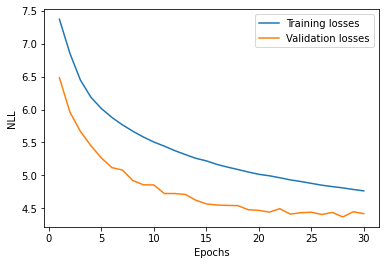

In [21]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

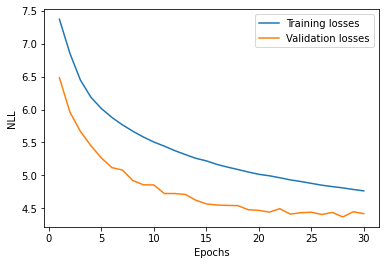

In [22]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [43]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the <unk> , and the <unk> , and the <unk>
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = = = = = = = =
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | season , and the <unk> , and the <unk> ,
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and the <unk> , and the <unk> , and the
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ <unk> , and the <unk> , and the <unk>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | ( <unk> , and the <unk> , and the <unk>
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in So

### submit

In [ ]:
pwd

'/content/handout/hw4'

In [23]:
run_id

'1606474229'

In [ ]:
pwd

'/content/handout/hw4'

In [25]:
%cd /content/handout
!make runid=1606474229 epoch=28

%cd /content/handout/hw4

/content/handout
cp hw4/experiments/1606474229/predictions-test-28.npy predictions.npy
cp hw4/experiments/1606474229/generated-28.txt generated.txt
cp hw4/experiments/1606474229/generated_logits-test-28.npy generated_logits.npy
cp hw4/training.ipynb training.ipynb
tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy
training.ipynb
predictions.npy
generated.txt
generated_logits.npy
rm -f generated.txt predictions.npy training.ipynb generated_logits.npy
/content/handout/hw4
